**@NuttidaLab: Tutorial on Bayesian Modeling**\
Date: 20th November 2024\
Author: Rudra

In [1]:
# # !conda create -n "tutorial" python=3.9 
# !conda activate tutorial 
# !pip install cmdstanpy
# !pip install pymc
# !pip install dynamax
# !pip install scipy==1.12
# !pip install ipywidgets
# !pip install seaborn
# !pip install numpyro
# !install_cmdstan

# # Optionally
# !conda update --all
# !conda install -c anaconda notebook 
# !conda install -c conda-forge jupyter_contrib_nbextensions 

In [2]:
# @utility
# Math imports
import math
from functools import partial
from itertools import count
import numpy as np
from scipy.stats import norm, poisson, expon, uniform, binom, beta, halfnorm
import jax.numpy as jnp
import jax.random as jr
# from jax import vmap

# Data imports
import tempfile
import pandas as pd

# Model imports
# import pymc as pm
from cmdstanpy import CmdStanModel
from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import LinearRegressionHMM
from dynamax.utils.utils import find_permutation

# Plotting imports
from IPython.display import display
import ipywidgets as widgets
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
# import arviz as az
import seaborn as sns
#sns.set_theme(style="white") # options: darkgrid, whitegrid, dark, white, ticks
# az.style.use("arviz-white")
plt.rcParams['figure.dpi'] = 300

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
time_by_neur_by_region = {}

for region in ['ACC', 'amygdala', 'hippocampus', 'preSMA', 'vmPFC']:

    df_time_by_neur = pd.read_pickle(f'./data_files/time_by_neurs/{region}.pkl')
    time_by_neur_by_region[region] = df_time_by_neur.values.T
    print(f'{region}: {time_by_neur_by_region[region].shape}')


ACC: (170, 477)
amygdala: (328, 477)
hippocampus: (192, 477)
preSMA: (236, 477)
vmPFC: (116, 477)


In [30]:
region = 'amygdala'
tst = jnp.array(time_by_neur_by_region[region].reshape(328, 477, 1))
# tst = pd.read_pickle(f'./data_files/time_by_neurs/hippocampus_P54CS_R1.pkl')
tst.shape

(328, 477, 1)

In [31]:
# Initialize the parameters using K-Means on the full training set
key = jr.PRNGKey(0)
t_hmm = GaussianHMM(num_states=15, emission_dim=1, transition_matrix_stickiness=10.)
params, props = t_hmm.initialize(key=key, method="kmeans", emissions=tst)
params, lps = t_hmm.fit_em(params, props, tst, num_iters=100)

<Axes: >

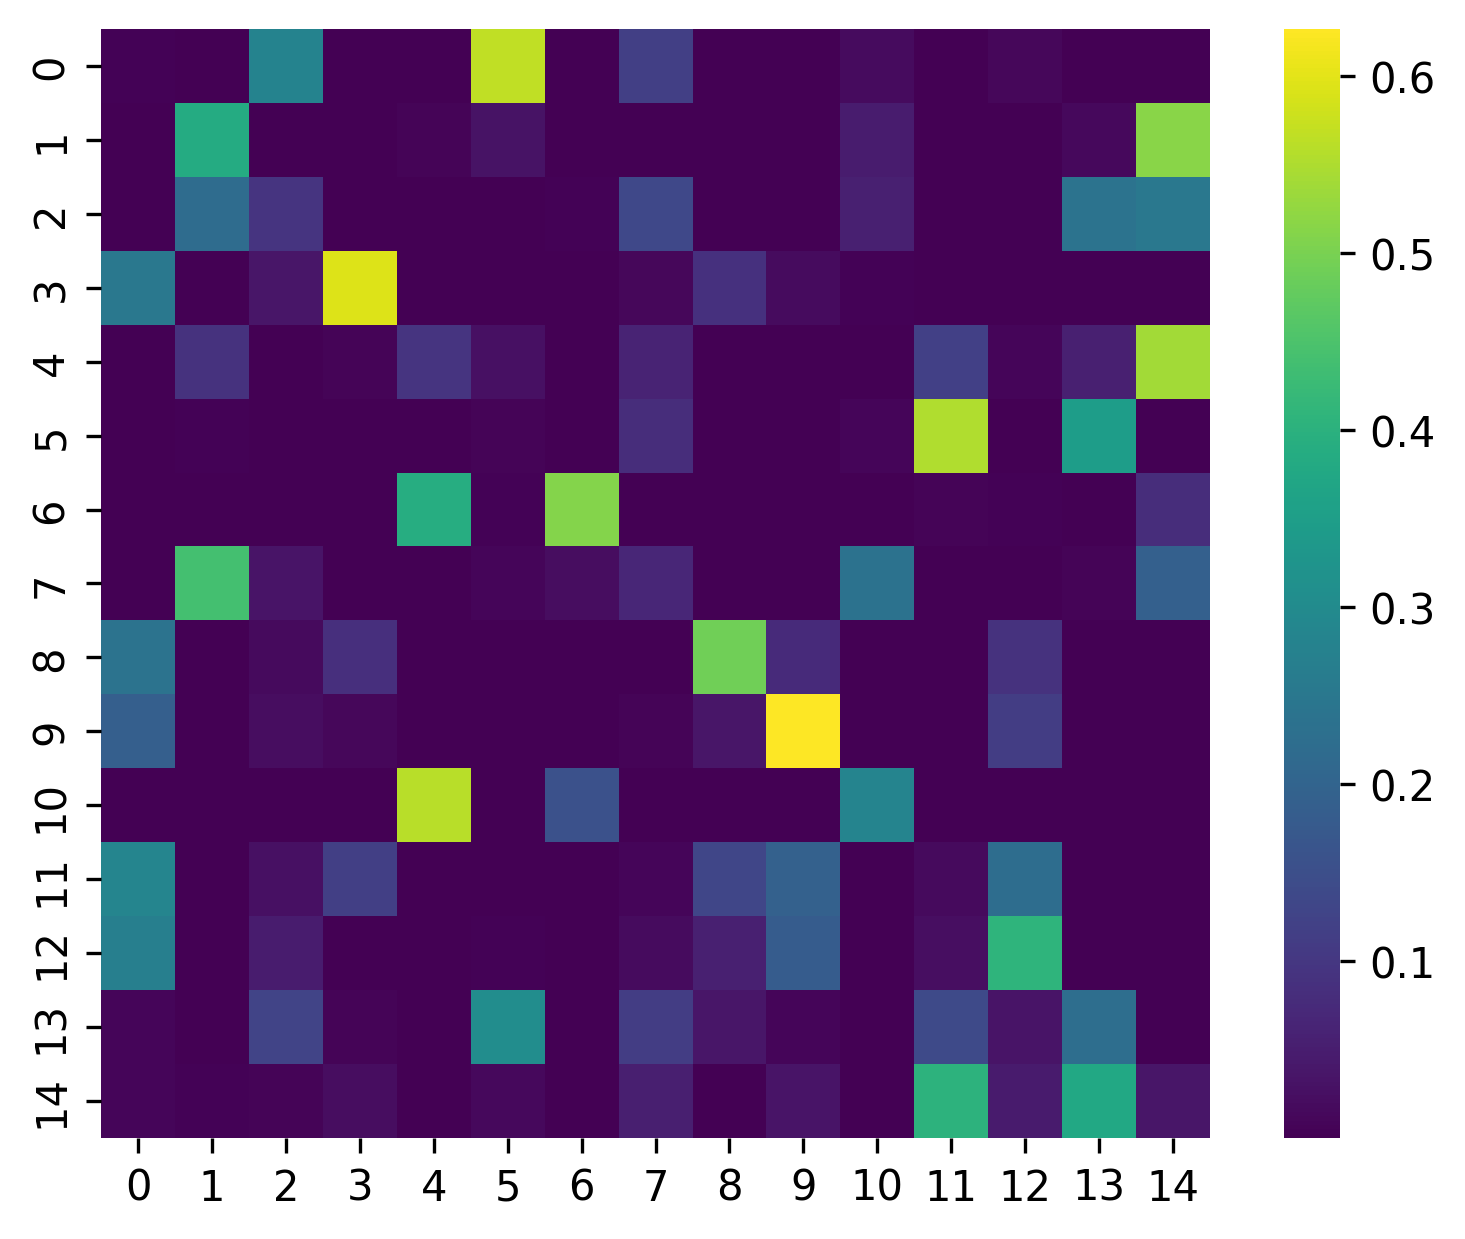

In [ ]:
# plt.figure(figsize=(5, 5))
sns.heatmap(params.transitions.transition_matrix, cmap="viridis", square=True, cbar=True)

In [27]:
def plot_states(true_states, most_likely_states, emissions, title="Did the HMM get it right?"):
    # Plot the true and inferred states
    fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [2, 2]}, figsize=(12, 6))

    for i, states in enumerate([true_states, most_likely_states]):
        offsets = 3 * jnp.arange(emission_dim)
        axs[i].imshow(states[None, :],
                    extent=(0, num_timesteps, em_min, em_max),
                    aspect="auto",
                    cmap="binary",
                    alpha=0.5)
        axs[i].plot(emissions + offsets, 'k-', marker='.')
        axs[i].scatter(jnp.arange(num_timesteps), emissions, c=emissions, cmap=col_line, marker='o', s=100)
        axs[i].set_xlim(0, num_timesteps)
        axs[i].set_ylim(em_min, em_max)
        axs[i].set_ylabel("emissions")
        axs[i].set_xlabel("time")

    axs[0].set_title("true states")
    axs[1].set_title("inferred states")
    plt.suptitle(title)

In [28]:
# Compute the most likely states
most_likely_states = t_hmm.most_likely_states(params, tst[0])
# plot_states(most_likely_states, most_likely_states, tst[0])

TypeError: Value 0     -1.141216
1     -1.141216
2     -0.410531
3     -0.775874
4      0.320153
         ...   
472    1.416180
473   -0.410531
474   -1.141216
475   -1.506558
476    0.320153
Name: 0, Length: 477, dtype: float64 with type <class 'pandas.core.series.Series'> is not a valid JAX type

In [24]:
change_vector = jnp.zeros(len(most_likely_states))
change_vector = jnp.where(jnp.diff(most_likely_states, prepend=most_likely_states[0]) != 0, 1, 0)
change_vector = change_vector.tolist()
print(change_vector)

[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 